In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/cleaned_rounds_data.csv')
df.head()

,round_winner,player_1_team_name,player_1_name,player_1_team_num,player_1_kills_total,player_1_deaths_total,player_1_has_defuser,player_1_has_helmet,player_1_armor_value,player_1_current_equip_value,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,G2 Esports,NiKo,0,1.0,1.0,0,0,0.0,700.0,...,0,0,0,0,1,0,1,1,0,0
1,1,G2 Esports,NiKo,0,1.0,2.0,0,1,100.0,4100.0,...,0,0,0,0,1,1,1,1,0,0
2,0,G2 Esports,NiKo,0,1.0,3.0,0,1,100.0,5100.0,...,0,0,0,0,1,1,0,1,0,0
3,1,G2 Esports,NiKo,0,3.0,4.0,0,1,100.0,2800.0,...,0,0,0,0,1,1,0,1,0,0
4,1,G2 Esports,NiKo,0,4.0,5.0,0,0,0.0,200.0,...,0,0,0,0,1,1,1,1,0,0


In [3]:
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
df.head()

,round_winner,player_1_team_num,player_1_kills_total,player_1_deaths_total,player_1_has_defuser,player_1_has_helmet,player_1_armor_value,player_1_current_equip_value,player_1_balance,player_1_AK-47,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,0,1.0,1.0,0,0,0.0,700.0,1650.0,0,...,0,0,0,0,1,0,1,1,0,0
1,1,0,1.0,2.0,0,1,100.0,4100.0,150.0,0,...,0,0,0,0,1,1,1,1,0,0
2,0,0,1.0,3.0,0,1,100.0,5100.0,1000.0,1,...,0,0,0,0,1,1,0,1,0,0
3,1,0,3.0,4.0,0,1,100.0,2800.0,400.0,0,...,0,0,0,0,1,1,0,1,0,0
4,1,0,4.0,5.0,0,0,0.0,200.0,3100.0,0,...,0,0,0,0,1,1,1,1,0,0


In [4]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [5]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [6]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [7]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [9]:
def logistic_regression(X, y, lr, epochs, e=1e-6):
    w = initialize_weights(X.shape[1])
    losses = []
    for epoch in range(epochs):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        loss = cross_entropy(y, y_pred)
        gradients = compute_gradients(X, y, y_pred)
        w -= lr * gradients
        new_loss = cross_entropy(y, sigmoid(np.dot(X, w)))
        losses.append(new_loss)
        if epoch % 250 == 0:
            print(f'Epoch {epoch}, loss {loss}')
        if np.abs(new_loss - loss) < e:
            print(np.abs(new_loss - loss))
            print(f'Converged at epoch {epoch}')
            break
    return w, losses

In [10]:
def predict_probabilities(X, w):
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    return probabilities

In [11]:
def predict(X, w, threshold=0.5):
    probabilities = predict_probabilities(X, w)
    return (probabilities >= threshold).astype(int)

In [12]:
X = df.drop(['round_winner'], axis=1)
X.head()

,player_1_team_num,player_1_kills_total,player_1_deaths_total,player_1_has_defuser,player_1_has_helmet,player_1_armor_value,player_1_current_equip_value,player_1_balance,player_1_AK-47,player_1_M4A1-S,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,0,1.0,1.0,0,0,0.0,700.0,1650.0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,0,1.0,2.0,0,1,100.0,4100.0,150.0,0,0,...,0,0,0,0,1,1,1,1,0,0
2,0,1.0,3.0,0,1,100.0,5100.0,1000.0,1,0,...,0,0,0,0,1,1,0,1,0,0
3,0,3.0,4.0,0,1,100.0,2800.0,400.0,0,0,...,0,0,0,0,1,1,0,1,0,0
4,0,4.0,5.0,0,0,0.0,200.0,3100.0,0,0,...,0,0,0,0,1,1,1,1,0,0


In [13]:
y = df['round_winner']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
lr = 0.1
epochs = 10000

In [17]:
w, losses = logistic_regression(X_train, y_train, lr, epochs)

Epoch 0, loss 0.766708956659906
Epoch 250, loss 0.4844654272451809
Epoch 500, loss 0.48226609011015314
Epoch 750, loss 0.4816162652266463
9.986341115153508e-07
Converged at epoch 992


In [18]:
print(f"Weights: {w}")

Weights: [ 3.47053727e-02  4.08586485e-02  2.72721619e-02  1.75308850e-01
  9.07223484e-02  3.73997839e-02 -1.04107792e-01 -4.08801253e-03
  1.22204157e-02 -2.27964747e-02  6.09160027e-02 -2.82465461e-02
 -2.50492444e-02 -3.51330390e-02  7.09301274e-02 -9.42312147e-02
  9.97441557e-03 -7.54133387e-02 -6.20452453e-02  5.93390140e-02
 -2.64943478e-02 -6.96031247e-03 -5.68448452e-02  5.99590991e-02
 -9.61439234e-02 -5.82751620e-02  1.76057101e-01 -5.66754764e-02
 -1.02442687e-02  8.02549943e-02  1.23511010e-01 -3.63804729e-02
 -2.78638779e-02  8.59009925e-02 -3.43205427e-02 -2.19861953e-02
  2.08900417e-02 -1.51978292e-02 -2.54780086e-02  1.38860534e-02
  5.00651413e-02 -4.05226128e-02 -6.25387495e-02 -1.62988467e-02
  1.35591910e-01 -1.74906633e-01 -5.81084010e-02  1.47558915e-02
 -1.08623170e-01 -4.13983070e-02  1.22821174e-01  1.80581816e-02
  4.60564553e-02 -1.43557168e-01 -3.15520040e-02  8.39533833e-02
  1.30087120e-01  2.96873943e-02  2.81780842e-02  3.14462965e-02
 -3.69631602e-02

In [19]:
y_pred = predict(X_test, w)
y_prob = predict_probabilities(X_test, w)

In [20]:
print(classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1864
           1       0.75      0.77      0.76      1993

    accuracy                           0.75      3857
   macro avg       0.75      0.75      0.75      3857
weighted avg       0.75      0.75      0.75      3857

                 Predicted Negative  Predicted Positive
Actual Negative                1365                 499
Actual Positive                 461                1532


In [21]:
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.8167556404497285


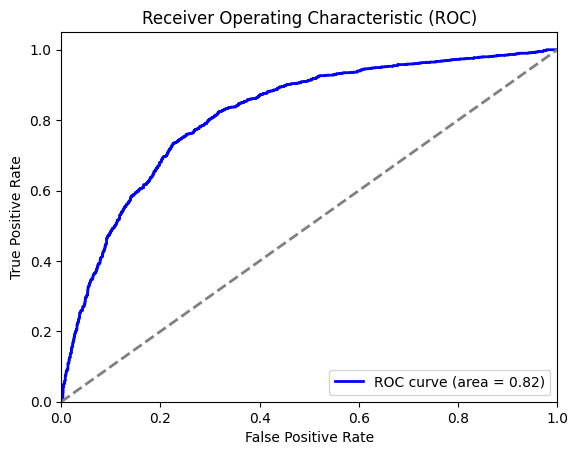

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()